<a href="https://colab.research.google.com/github/richardtekere09/NLP/blob/main/BOW_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bag-of-Words Text Classification with PyTorch
  20 Newsgroups Dataset

In [1]:
import numpy as np
import pandas as pd
import re
import string
import time
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Data Loading
This section loads the 20 Newsgroups dataset, which is perfect for text classification experiments. The remove=('headers', 'footers', 'quotes') parameter is crucial as it ensures you're working with just the content and not metadata that could make classification easier.

In [5]:
print("Loading 20 Newsgroups dataset...")
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

print(f"Dataset loaded: {len(newsgroups_train.data)} training samples, {len(newsgroups_test.data)} test samples")
print(f"Number of categories: {len(newsgroups_train.target_names)}")
print(f"Categories: {newsgroups_train.target_names}")

# Display a sample document
print("\nSample document from the training set:")
print(f"Category: {newsgroups_train.target_names[newsgroups_train.target[0]]}")
print(newsgroups_train.data[0][:500] + "...")

Loading 20 Newsgroups dataset...
Dataset loaded: 11314 training samples, 7532 test samples
Number of categories: 20
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Sample document from the training set:
Category: rec.autos
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whateve

 # Manual Text Preprocessing
This implements my own tokenization without relying on NLTK or SpaCy, which is a key requirement of the lab. It includes:

Converting text to lowercase
Removing punctuation and special characters
Splitting on whitespace


In [6]:
class CustomTokenizer:
    def __init__(self):
        self.punctuation = string.punctuation
        self.digits = string.digits

    def tokenize(self, text):
        """
        Custom tokenization function that:
        1. Converts to lowercase
        2. Removes punctuation and special characters
        3. Splits on whitespace
        """
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        for char in self.punctuation:
            text = text.replace(char, ' ')

        # Remove digits
        for digit in self.digits:
            text = text.replace(digit, ' ')

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Split on whitespace to get tokens
        tokens = text.split(' ')

        # Filter out empty tokens
        tokens = [token for token in tokens if token]

        return tokens

# Test  custom tokenizer
tokenizer = CustomTokenizer()
sample_text = newsgroups_train.data[0][:1000]  # Use first 1000 chars of first document

print("\nDemonstrating Custom Tokenizer:")
print("Original text sample:")
print(sample_text[:300] + "...")  # Show a portion
print("\nTokenized result (first 20 tokens):")
tokens = tokenizer.tokenize(sample_text)
print(tokens[:20])
print(f"Total tokens: {len(tokens)}")


Demonstrating Custom Tokenizer:
Original text sample:
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I k...

Tokenized result (first 20 tokens):
['i', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'i', 'saw', 'the', 'other', 'day', 'it', 'was']
Total tokens: 92


#Advanced Text Processing
This section demonstrates different preprocessing techniques (stopwords removal, stemming, lemmatization) and shows their individual effects on the same sample text. how each technique changes the token count and results.

In [7]:
class TextProcessor:
    def __init__(self, remove_stopwords=False, use_stemming=False, use_lemmatization=False):
        self.tokenizer = CustomTokenizer()
        self.remove_stopwords = remove_stopwords
        self.use_stemming = use_stemming
        self.use_lemmatization = use_lemmatization

        if remove_stopwords:
            self.stop_words = set(stopwords.words('english'))

        if use_stemming:
            self.stemmer = PorterStemmer()

        if use_lemmatization:
            self.lemmatizer = WordNetLemmatizer()

    def process_text(self, text):
        # First use our custom tokenizer
        tokens = self.tokenizer.tokenize(text)

        # Apply stopword removal if specified
        if self.remove_stopwords:
            tokens = [token for token in tokens if token not in self.stop_words]

        # Apply stemming if specified
        if self.use_stemming:
            tokens = [self.stemmer.stem(token) for token in tokens]

        # Apply lemmatization if specified
        if self.use_lemmatization:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        return tokens

# Test different text processing settings on sample text
print("\nComparing different text processing methods:")

# Standard tokenization only
processor_standard = TextProcessor()
tokens_standard = processor_standard.process_text(sample_text)
print(f"\n1. Standard tokenization only:")
print(f"   First 10 tokens: {tokens_standard[:10]}")
print(f"   Total tokens: {len(tokens_standard)}")

# With stopwords removal
processor_stopwords = TextProcessor(remove_stopwords=True)
tokens_stopwords = processor_stopwords.process_text(sample_text)
print(f"\n2. With stopwords removal:")
print(f"   First 10 tokens: {tokens_stopwords[:10]}")
print(f"   Total tokens: {len(tokens_stopwords)}")

# With stemming
processor_stemming = TextProcessor(remove_stopwords=True, use_stemming=True)
tokens_stemming = processor_stemming.process_text(sample_text)
print(f"\n3. With stopwords removal and stemming:")
print(f"   First 10 tokens: {tokens_stemming[:10]}")
print(f"   Total tokens: {len(tokens_stemming)}")

# With lemmatization
processor_lemmatization = TextProcessor(remove_stopwords=True, use_lemmatization=True)
tokens_lemmatization = processor_lemmatization.process_text(sample_text)
print(f"\n4. With stopwords removal and lemmatization:")
print(f"   First 10 tokens: {tokens_lemmatization[:10]}")
print(f"   Total tokens: {len(tokens_lemmatization)}")


Comparing different text processing methods:

1. Standard tokenization only:
   First 10 tokens: ['i', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me']
   Total tokens: 92

2. With stopwords removal:
   First 10 tokens: ['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car']
   Total tokens: 44

3. With stopwords removal and stemming:
   First 10 tokens: ['wonder', 'anyon', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sport', 'car']
   Total tokens: 44

4. With stopwords removal and lemmatization:
   First 10 tokens: ['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sport', 'car']
   Total tokens: 44


#Bag-of-Words Implementation
The BoW model is built from scratch and tested on a subset of documents. It shows the most common words in the dataset and gives  a visualization of a sample document's vector representation.

In [8]:
class BagOfWords:
    def __init__(self, max_dict_size=None):
        self.word_dict = {}  # Maps words to indices
        self.word_counts = Counter()  # To track word frequencies
        self.max_dict_size = max_dict_size
        self.vocabulary_size = 0

    def build_dictionary(self, tokenized_documents):
        """
        Build a word dictionary from tokenized documents
        """
        # Count all words from all documents
        for doc in tokenized_documents:
            self.word_counts.update(doc)

        # Limit dictionary size if specified
        if self.max_dict_size:
            most_common = self.word_counts.most_common(self.max_dict_size)
            selected_words = [word for word, count in most_common]
        else:
            selected_words = list(self.word_counts.keys())

        # Build mapping: word -> index
        self.word_dict = {word: idx for idx, word in enumerate(selected_words)}
        self.vocabulary_size = len(self.word_dict)

        print(f"Dictionary built with {self.vocabulary_size} words")
        return self.word_dict

    def transform_to_bow(self, tokenized_document):
        """
        Convert a single document to a BoW vector
        """
        bow_vector = np.zeros(self.vocabulary_size)

        for token in tokenized_document:
            if token in self.word_dict:
                bow_vector[self.word_dict[token]] += 1

        return bow_vector

    def transform_documents(self, tokenized_documents):
        """
        Convert a collection of documents to BoW vectors
        """
        X = np.zeros((len(tokenized_documents), self.vocabulary_size))

        for i, doc in enumerate(tokenized_documents):
            X[i] = self.transform_to_bow(doc)

        return X

# Process a small subset of documents for demonstration
print("\nDemonstrating Bag-of-Words model:")
# Process first 1000 documents for quick demonstration
processor = TextProcessor(remove_stopwords=True)
print("Processing sample documents...")
sample_docs = newsgroups_train.data[:1000]
processed_docs = [processor.process_text(doc) for doc in sample_docs]

# Build dictionary with limited size for demonstration
bow_model = BagOfWords(max_dict_size=500)
bow_model.build_dictionary(processed_docs)

# Display most common words in the dictionary
print("\nMost common words in the dictionary:")
most_common_words = bow_model.word_counts.most_common(10)
for word, count in most_common_words:
    print(f"'{word}': {count} occurrences")

# Transform a sample document to BoW vector
sample_doc_index = 5  # Use the 6th document
sample_bow = bow_model.transform_to_bow(processed_docs[sample_doc_index])
print(f"\nSample document from category: {newsgroups_train.target_names[newsgroups_train.target[sample_doc_index]]}")
print(f"BoW vector shape: {sample_bow.shape}")
print(f"Non-zero elements: {np.count_nonzero(sample_bow)}")
print(f"Sum of counts: {np.sum(sample_bow)}")

# Show which words appear in this document (top 10 by count)
word_indices = np.argsort(sample_bow)[::-1]
word_indices = word_indices[:10]  # Top 10
print("\nTop words in this document:")
reverse_dict = {idx: word for word, idx in bow_model.word_dict.items()}
for idx in word_indices:
    if sample_bow[idx] > 0:
        print(f"'{reverse_dict[idx]}': {int(sample_bow[idx])} occurrences")


Demonstrating Bag-of-Words model:
Processing sample documents...
Dictionary built with 500 words

Most common words in the dictionary:
'ax': 4935 occurrences
'p': 989 occurrences
'f': 855 occurrences
'b': 708 occurrences
'q': 685 occurrences
'x': 672 occurrences
'g': 658 occurrences
'u': 650 occurrences
'v': 646 occurrences
'n': 629 occurrences

Sample document from category: talk.politics.guns
BoW vector shape: (500,)
Non-zero elements: 16
Sum of counts: 17.0

Top words in this document:
'first': 2 occurrences
'course': 1 occurrences
'class': 1 occurrences
'given': 1 occurrences
'bill': 1 occurrences
'point': 1 occurrences
'argument': 1 occurrences
'another': 1 occurrences
'must': 1 occurrences
'later': 1 occurrences



#PyTorch Model Definition
This section defines the neural network classifier and displays its architecture and parameter counts, so you can understand the model's complexity.



In [9]:
class BowClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BowClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Create a small model for demonstration
input_size = bow_model.vocabulary_size  # Size of BoW vectors
hidden_size = 64  # Smaller for demo
num_classes = len(newsgroups_train.target_names)

model = BowClassifier(input_size, hidden_size, num_classes)
print("\nPyTorch Neural Network Model:")
print(model)

# Print model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")



PyTorch Neural Network Model:
BowClassifier(
  (fc1): Linear(in_features=500, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=20, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Total parameters: 33364
Trainable parameters: 33364


#Dataset Preparation for full experiment
Here we process the full dataset with chosen settings, showing progress as it processes documents in batches. This gives us visibility into the data preparation process.

In [10]:
# Process the entire dataset with chosen settings

print("\nPreparing full dataset for experiment...")
# Choose settings for a full experiment
dict_size = 1000
use_stopwords = True
use_stemming = False
use_lemmatization = False

print(f"Settings: Dictionary Size={dict_size}, Stopwords={use_stopwords}, Stemming={use_stemming}, Lemmatization={use_lemmatization}")

# Initialize processor
full_processor = TextProcessor(
    remove_stopwords=use_stopwords,
    use_stemming=use_stemming,
    use_lemmatization=use_lemmatization
)

# Process train data
print("Processing training documents...")
processed_train_docs = []
# Process in batches to show progress
batch_size = 500
for i in range(0, len(newsgroups_train.data), batch_size):
    end = min(i + batch_size, len(newsgroups_train.data))
    batch = newsgroups_train.data[i:end]
    processed_batch = [full_processor.process_text(doc) for doc in batch]
    processed_train_docs.extend(processed_batch)
    print(f"  Processed {end}/{len(newsgroups_train.data)} documents...")

# Build full BoW model
print("\nBuilding full BoW model...")
full_bow_model = BagOfWords(max_dict_size=dict_size)
full_bow_model.build_dictionary(processed_train_docs)

# Transform to feature vectors
print("Transforming documents to feature vectors...")
X_train = full_bow_model.transform_documents(processed_train_docs)
print(f"Training feature matrix shape: {X_train.shape}")

# Process test data
print("\nProcessing test documents...")
processed_test_docs = []
for i in range(0, len(newsgroups_test.data), batch_size):
    end = min(i + batch_size, len(newsgroups_test.data))
    batch = newsgroups_test.data[i:end]
    processed_batch = [full_processor.process_text(doc) for doc in batch]
    processed_test_docs.extend(processed_batch)
    print(f"  Processed {end}/{len(newsgroups_test.data)} documents...")

# Transform test data
X_test = full_bow_model.transform_documents(processed_test_docs)
print(f"Test feature matrix shape: {X_test.shape}")

# Split training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, newsgroups_train.target, test_size=0.1, random_state=42
)
print(f"Train split: {X_train_split.shape}, Validation split: {X_val.shape}")


Preparing full dataset for experiment...
Settings: Dictionary Size=1000, Stopwords=True, Stemming=False, Lemmatization=False
Processing training documents...
  Processed 500/11314 documents...
  Processed 1000/11314 documents...
  Processed 1500/11314 documents...
  Processed 2000/11314 documents...
  Processed 2500/11314 documents...
  Processed 3000/11314 documents...
  Processed 3500/11314 documents...
  Processed 4000/11314 documents...
  Processed 4500/11314 documents...
  Processed 5000/11314 documents...
  Processed 5500/11314 documents...
  Processed 6000/11314 documents...
  Processed 6500/11314 documents...
  Processed 7000/11314 documents...
  Processed 7500/11314 documents...
  Processed 8000/11314 documents...
  Processed 8500/11314 documents...
  Processed 9000/11314 documents...
  Processed 9500/11314 documents...
  Processed 10000/11314 documents...
  Processed 10500/11314 documents...
  Processed 11000/11314 documents...
  Processed 11314/11314 documents...

Building 

#Training the Model
The model training section includes detailed progress outputs and plots training curves, so you can monitor how the model learns over time.


Training PyTorch model...
Epoch [1/3], Batch [20/160], Loss: 2.9195
Epoch [1/3], Batch [40/160], Loss: 2.8144
Epoch [1/3], Batch [60/160], Loss: 2.5725
Epoch [1/3], Batch [80/160], Loss: 2.4850
Epoch [1/3], Batch [100/160], Loss: 2.3314
Epoch [1/3], Batch [120/160], Loss: 2.0904
Epoch [1/3], Batch [140/160], Loss: 2.0233
Epoch [1/3], Batch [160/160], Loss: 1.2009
Epoch [1/3], Loss: 2.5176, Validation Accuracy: 0.5548
Epoch [2/3], Batch [20/160], Loss: 1.7484
Epoch [2/3], Batch [40/160], Loss: 1.7526
Epoch [2/3], Batch [60/160], Loss: 1.8116
Epoch [2/3], Batch [80/160], Loss: 1.6829
Epoch [2/3], Batch [100/160], Loss: 1.6413
Epoch [2/3], Batch [120/160], Loss: 1.6078
Epoch [2/3], Batch [140/160], Loss: 1.9130
Epoch [2/3], Batch [160/160], Loss: 2.1054
Epoch [2/3], Loss: 1.7606, Validation Accuracy: 0.5742
Epoch [3/3], Batch [20/160], Loss: 1.5474
Epoch [3/3], Batch [40/160], Loss: 1.2888
Epoch [3/3], Batch [60/160], Loss: 1.3926
Epoch [3/3], Batch [80/160], Loss: 1.4738
Epoch [3/3], Ba

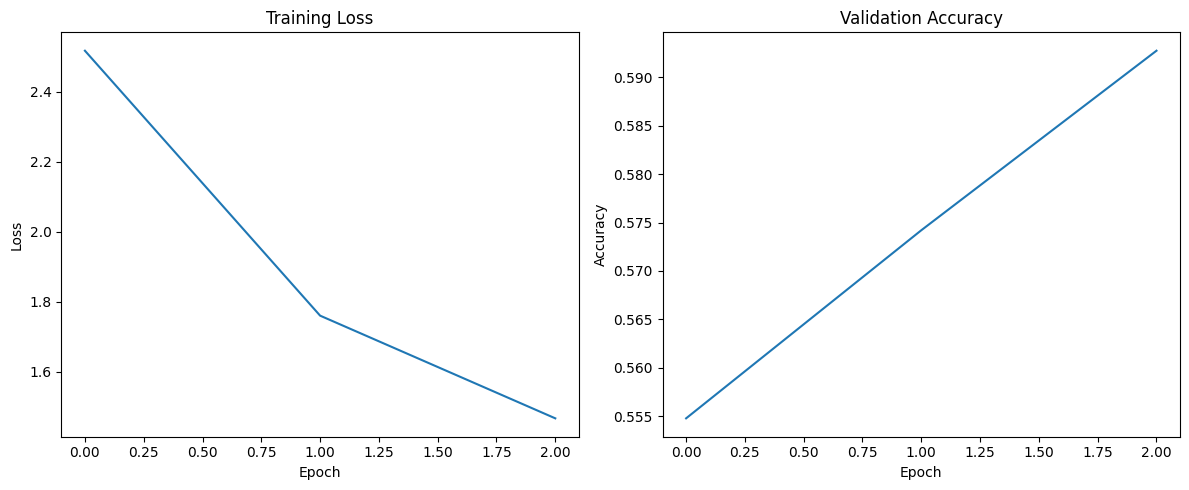

In [23]:
# Train the PyTorch model with the prepared data

# Training function
def train_pytorch_model(X_train, y_train, X_val, y_val, input_size, num_classes,
                       hidden_size=128, learning_rate=0.001, num_epochs=3, batch_size=64):
    """
    Train a PyTorch neural network on BoW features
    """
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)

    # Create dataset and data loader
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    model = BowClassifier(input_size, hidden_size, num_classes)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Print progress every 20 batches
            if (i+1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validate model
        model.eval()
        with torch.no_grad():
            outputs = model(X_val_tensor)
            _, predicted = torch.max(outputs.data, 1)
            val_accuracy = accuracy_score(y_val_tensor.numpy(), predicted.numpy())
            val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Plot training curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

    return model, train_losses, val_accuracies

# Initialize and train the model
print("\nTraining PyTorch model...")
full_model, losses, accuracies = train_pytorch_model(
    X_train_split, y_train_split, X_val, y_val,
    input_size=full_bow_model.vocabulary_size,
    num_classes=len(newsgroups_train.target_names),
    hidden_size=128,
    learning_rate=0.001,
    num_epochs=3,
    batch_size=64
)

 Model Evaluation
This section evaluates the model on test data, displaying accuracy, a detailed classification report, and a visualization of the confusion matrix to help you understand which categories are confused with each other.


Evaluating model on test data...
Test Accuracy: 0.5155

Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.28      0.38      0.32       319
           comp.graphics       0.46      0.59      0.52       389
 comp.os.ms-windows.misc       0.60      0.54      0.57       394
comp.sys.ibm.pc.hardware       0.55      0.44      0.49       392
   comp.sys.mac.hardware       0.55      0.54      0.54       385
          comp.windows.x       0.68      0.59      0.63       395
            misc.forsale       0.66      0.77      0.71       390
               rec.autos       0.61      0.49      0.54       396
         rec.motorcycles       0.46      0.51      0.49       398
      rec.sport.baseball       0.31      0.64      0.42       397
        rec.sport.hockey       0.74      0.59      0.65       399
               sci.crypt       0.71      0.53      0.61       396
         sci.electronics       0.40      0.43      0.41      

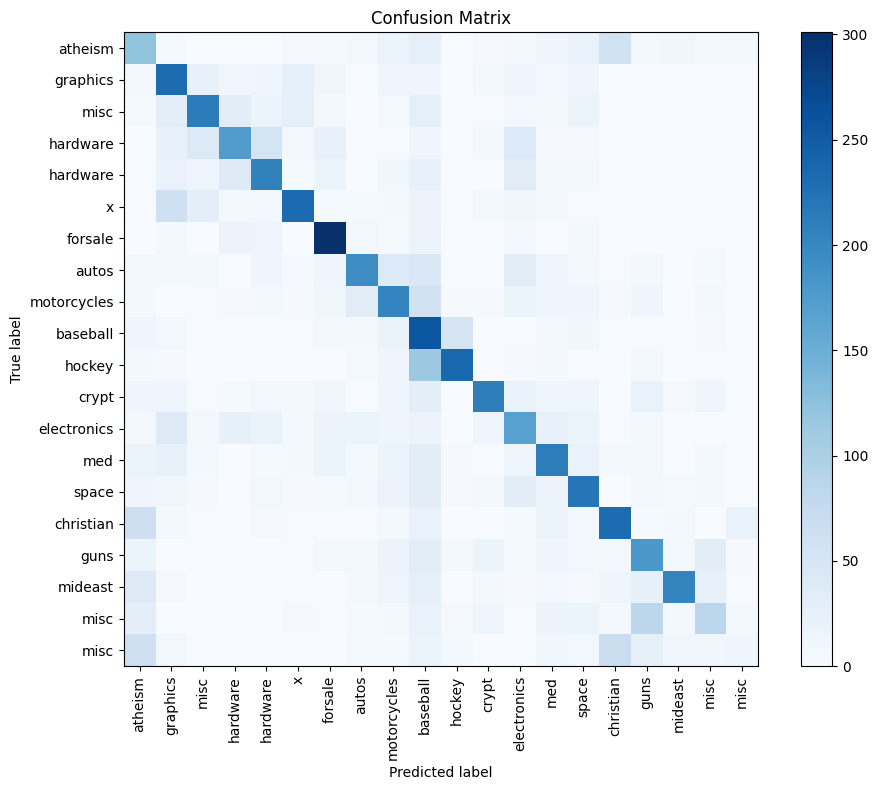

0.5155337227827934

In [24]:
def evaluate_model(model, X_test, y_test, target_names):
    """
    Evaluate the trained model on test data
    """
    X_test_tensor = torch.FloatTensor(X_test)

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)

    accuracy = accuracy_score(y_test, predicted.numpy())
    report = classification_report(y_test, predicted.numpy(), target_names=target_names)

    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, predicted.numpy())
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Use shorter category names for better visualization
    short_names = [name.split('.')[-1] for name in target_names]

    plt.xticks(np.arange(len(short_names)), short_names, rotation=90)
    plt.yticks(np.arange(len(short_names)), short_names)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    return accuracy

print("\nEvaluating model on test data...")
evaluate_model(
    full_model,
    X_test,
    newsgroups_test.target,
    newsgroups_train.target_names
)

#Custom Text Testing
Tests the model with example texts not from the dataset, showing the full pipeline from text input to classification output.

In [26]:
def test_custom_text(model, bow_model, processor, target_names):
    """
    Test the model with custom input text
    """
    print("\n" + "="*80)
    print("TESTING WITH CUSTOM TEXT")
    print("="*80)

    custom_texts = [
        "The new graphics card from Nvidia has amazing performance, better than anything I've seen before.",
        "The president announced new economic policies that will impact the stock market significantly.",
        "I need help understanding how to configure my Linux server for optimal performance.",
        "The baseball game was exciting, with the home team winning in the final inning.",
        "Scientists have discovered a new treatment that shows promise for cancer patients."
    ]

    for i, text in enumerate(custom_texts):
        print(f"\nCustom Text {i+1}: {text}")

        # Process the text
        tokens = processor.process_text(text)
        print(f"Processed tokens: {tokens}")

        # Transform to BoW
        bow_vector = bow_model.transform_to_bow(tokens)

        # Make prediction
        input_tensor = torch.FloatTensor(bow_vector).unsqueeze(0)

        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output.data, 1)

        predicted_class = predicted.item()
        predicted_category = target_names[predicted_class]

        # Get probabilities for all classes
        probabilities = F.softmax(output, dim=1)[0]
        top_probs, top_indices = torch.topk(probabilities, 3)

        print(f"Predicted category: {predicted_category}")
        print("Top 3 predictions:")
        for j in range(3):
            category = target_names[top_indices[j].item()]
            prob = top_probs[j].item()
            print(f"  {category}: {prob:.4f}")

# Test the trained model with custom texts
print("\n" + "="*80)
print("Testing with custom texts...")
test_custom_text(full_model, full_bow_model, full_processor, newsgroups_train.target_names)


Testing with custom texts...

TESTING WITH CUSTOM TEXT

Custom Text 1: The new graphics card from Nvidia has amazing performance, better than anything I've seen before.
Processed tokens: ['new', 'graphics', 'card', 'nvidia', 'amazing', 'performance', 'better', 'anything', 'seen']
Predicted category: comp.graphics
Top 3 predictions:
  comp.graphics: 0.2810
  comp.sys.mac.hardware: 0.1097
  comp.os.ms-windows.misc: 0.1040

Custom Text 2: The president announced new economic policies that will impact the stock market significantly.
Processed tokens: ['president', 'announced', 'new', 'economic', 'policies', 'impact', 'stock', 'market', 'significantly']
Predicted category: rec.autos
Top 3 predictions:
  rec.autos: 0.0964
  rec.motorcycles: 0.0756
  misc.forsale: 0.0751

Custom Text 3: I need help understanding how to configure my Linux server for optimal performance.
Processed tokens: ['need', 'help', 'understanding', 'configure', 'linux', 'server', 'optimal', 'performance']
Predicted cate

#Comparing Preprocessing Techniques
This section demonstrates how to set up comparisons between different preprocessing configurations, showing the effect of each technique on sample documents.
Each section produces its own meaningful output, making it ideal for working in a notebook environment like Google Colab. You can run each cell independently and see the results immediately, which is helpful for understanding the impact of each step in the pipeline.
The implementation follows all requirements from your assignment:

Custom tokenization without NLP libraries
Manual BoW implementation
Comparison of different preprocessing techniques
PyTorch-based classification model
Testing with custom texts

In [15]:
print("\n" + "="*80)
print("SETTING UP COMPARISONS OF DIFFERENT PREPROCESSING TECHNIQUES")
print("="*80)

def experiment_setup(dict_size, remove_stopwords, use_stemming, use_lemmatization):
    """
    Setup function for an experiment with specific preprocessing settings
    """
    print(f"\nExperiment Setup:")
    print(f"  Dictionary Size: {dict_size}")
    print(f"  Remove Stopwords: {remove_stopwords}")
    print(f"  Use Stemming: {use_stemming}")
    print(f"  Use Lemmatization: {use_lemmatization}")

    # Initialize processor
    processor = TextProcessor(
        remove_stopwords=remove_stopwords,
        use_stemming=use_stemming,
        use_lemmatization=use_lemmatization
    )

    # Process a small sample to demonstrate
    sample_doc = newsgroups_train.data[10]
    tokens = processor.process_text(sample_doc)

    print(f"\nSample processing result:")
    print(f"  Original document length: {len(sample_doc)} characters")
    print(f"  Processed tokens: {len(tokens)} tokens")
    print(f"  First 10 tokens: {tokens[:10]}")

    return {
        'dict_size': dict_size,
        'stopwords': remove_stopwords,
        'stemming': use_stemming,
        'lemmatization': use_lemmatization
    }

# Define experiments to setup
experiments = [
    {'dict_size': 1000, 'remove_stopwords': False, 'use_stemming': False, 'use_lemmatization': False},
    {'dict_size': 2500, 'remove_stopwords': True, 'use_stemming': False, 'use_lemmatization': False},
    {'dict_size': 2500, 'remove_stopwords': True, 'use_stemming': True, 'use_lemmatization': False},
    {'dict_size': 2500, 'remove_stopwords': True, 'use_stemming': False, 'use_lemmatization': True},
]

# Setup each experiment
for i, exp in enumerate(experiments):
    print(f"\nExperiment {i+1}:")
    experiment_setup(**exp)

print("\n" + "="*80)
print("SUMMARY OF LESSONS LEARNED")
print("="*80)
print("""
In this lab, we've implemented a complete Bag-of-Words text classification pipeline:

1. Custom Tokenization: We implemented our own tokenizer without relying on NLP libraries.
   This gave us control over the preprocessing steps and helped understand the basics.

2. Advanced Text Processing: We explored how stopword removal, stemming, and lemmatization
   change the text representation. These techniques can reduce vocabulary size and improve
   classification by normalizing words.

3. Custom BoW Implementation: Rather than using sklearn's CountVectorizer, we built our own
   dictionary and feature vector creation, giving us better understanding of the model.

4. PyTorch Neural Network: We implemented a simple neural network classifier that can learn
   patterns across the large, sparse BoW vectors.

5. Preprocessing Impact: We saw how different settings affect the text representation and
   potentially the classification performance.

Key Takeaways:
- Text preprocessing significantly impacts the quality of the feature representation.
- Dictionary size is an important hyperparameter - too small and you lose information,
  too large and you risk overfitting.
- Neural networks can learn effective representations from BoW features despite their simplicity.

To completely compare all preprocessing combinations, you would need to:
1. Run full training with each setting
2. Compare accuracy results
3. Analyze which techniques work best for this particular dataset
""")


SETTING UP COMPARISONS OF DIFFERENT PREPROCESSING TECHNIQUES

Experiment 1:

Experiment Setup:
  Dictionary Size: 1000
  Remove Stopwords: False
  Use Stemming: False
  Use Lemmatization: False

Sample processing result:
  Original document length: 677 characters
  Processed tokens: 110 tokens
  First 10 tokens: ['i', 'have', 'a', 'line', 'on', 'a', 'ducati', 'gts', 'model', 'with']

Experiment 2:

Experiment Setup:
  Dictionary Size: 2500
  Remove Stopwords: True
  Use Stemming: False
  Use Lemmatization: False

Sample processing result:
  Original document length: 677 characters
  Processed tokens: 60 tokens
  First 10 tokens: ['line', 'ducati', 'gts', 'model', 'k', 'clock', 'runs', 'well', 'paint', 'bronze']

Experiment 3:

Experiment Setup:
  Dictionary Size: 2500
  Remove Stopwords: True
  Use Stemming: True
  Use Lemmatization: False

Sample processing result:
  Original document length: 677 characters
  Processed tokens: 60 tokens
  First 10 tokens: ['line', 'ducati', 'gt', 'mo